<a id="id_0"></a>
# Build Label File
## Context
**Project Name:** Predict Netflix titles that Mum will watch       
**Written by:** Claudia Wallis         
**Created:** 27/02/2022           
**Last modifed:** 27/02/20212           

## Objective
**Build label file to identify Netflix titles that Mum will watch**           

## Input Data 
1. netflix_viewing_history_mum_27022022.csv
2. [netflix_dataset_latest_2021_kaggle.xlsx](https://www.kaggle.com/syedmubarak/netflix-dataset-latest-2021)


## Table of Contents
1. [Set Up](#id_1)
    - 1a. Import packages
    - 1b. Update variables
2. [Load Data](#id_2)
    - 2a. Load data
    - 2b. Explore data
    - 2c. Clean
    - 2d. Checks
    - 2e. Visualise data sets over time
3. [Build Label File](#id_3)
4. [Feature Engineering](#id_4)
    - 4a. Handle Categorical columns with minimal unique values
    - 4b. Handle Categorical columns with multiple values per cell
    - 4c. NLP feature engineering of text feature = Summary
    - 4d. Handling Nulls
5. [Save Label File](#id_5)

<a id="id_1"></a>
## 1. Set Up
#### 1a) Import packages

In [1]:
# base packages
import pandas as pd
import numpy as np

# etc
import time
import pickle
import os

# visualisation and data wrangling
import seaborn as sns
import matplotlib.pyplot as plt

# NLP related
import re
from nltk.probability import FreqDist
from nltk import word_tokenize
from nltk.corpus import stopwords
from textblob import TextBlob
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA

# pipeline functions
os.chdir('C:\\Users\\claud\\Documents\\code\\')
import pipeline; import importlib; importlib.reload(pipeline)
from pipeline.fns import data_summary

# python related
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.filterwarnings("ignore")
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

#### 1b) Update variables

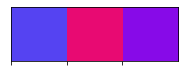

In [2]:
# update paths
path = 'C:\\Users\\claud\\Documents\\data\\'

# set key colours
palette = ['#5543F2', '#E80A72', '#870AE8']
sns.set_palette(palette)
sns.palplot(sns.color_palette())

# set options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows',None)
pd.set_option('float_format', '{:f}'.format)

<a id="id_2"></a>
## 2. Load Data
#### 2a) Load data

In [3]:
%%time
mum_history_df = pd.read_csv(path + 'input_data\\netflix_viewing_history_mum_27022022.csv')
kaggle_netflix = pd.read_excel(path + 'input_data\\netflix_dataset_latest_2021_kaggle.xlsx')

Wall time: 9.44 s


#### 2b) Explore data

In [4]:
print('Kaggle Netflix Data:\nShape = ' + str(kaggle_netflix.shape))
display(kaggle_netflix.head())
kaggle_netflix['Netflix Release Date'] = pd.to_datetime(kaggle_netflix['Netflix Release Date'])
display(kaggle_netflix['Netflix Release Date'].describe())


print("\n\nMum's viewing history:\nShape = " + str(mum_history_df.shape))
display(mum_history_df.head())
mum_history_df['Date'] = pd.to_datetime(mum_history_df['Date'], dayfirst = True)
display(mum_history_df['Date'].describe())



Kaggle Netflix Data:
Shape = (9425, 29)


,Title,Genre,Tags,Languages,Series or Movie,Hidden Gem Score,Country Availability,Runtime,Director,Writer,Actors,View Rating,IMDb Score,Rotten Tomatoes Score,Metacritic Score,Awards Received,Awards Nominated For,Boxoffice,Release Date,Netflix Release Date,Production House,Netflix Link,IMDb Link,Summary,IMDb Votes,Image,Poster,TMDb Trailer,Trailer Site
0,Lets Fight Ghost,"Crime, Drama, Fantasy, Horror, Romance","Comedy Programmes,Romantic TV Comedies,Horror Programmes,Thai TV Programmes","Swedish, Spanish",Series,4.300000,Thailand,< 30 minutes,Tomas Alfredson,John Ajvide Lindqvist,"Lina Leandersson, Kåre Hedebrant, Per Ragnar, Henrik Dahl",R,7.900000,98.000000,82.000000,74.000000,57.000000,2122065.000000,2008-12-12,2021-03-04,"Canal+, Sandrew Metronome",https://www.netflix.com/watch/81415947,https://www.imdb.com/title/tt1139797,"A med student with a supernatural gift tries to cash in on his abilities by facing off against ghosts, till a wandering spirit brings romance instead.",205926.000000,https://occ-0-4708-64.1.nflxso.net/dnm/api/v6/evlCitJPPCVCry0BZlEFb5-QjKc/AAAABcmgLCxN8dNahdY2kgd1hhcL2a6XrE92x24Bx5h6JFUvH5zMrv6lFWl_aWMt33b6DHvkgsUeDx_8Q1rmopwT3fuF8Rq3S1hrkvFf3uzVv2sb3zrtU-LM1Zy1FfrAKD3nKNyA_RQWrmw.jpg?r=cd0,https://m.media-amazon.com/images/M/MV5BOWM4NTY2NTMtZDZlZS00NTgyLWEzZDMtODE3ZGI1MzI3ZmU5XkEyXkFqcGdeQXVyNzI1NzMxNzM@._V1_SX300.jpg,https://www.youtube.com/watch?v=LqB6XJix-dM,YouTube
1,HOW TO BUILD A GIRL,Comedy,"Dramas,Comedies,Films Based on Books,British",English,Movie,7.000000,Canada,1-2 hour,Coky Giedroyc,Caitlin Moran,"Cleo, Paddy Considine, Beanie Feldstein, Dónal Finn",R,5.800000,79.000000,69.000000,1.000000,NaN,70632.000000,2020-05-08,2021-03-04,"Film 4, Monumental Pictures, Lionsgate",https://www.netflix.com/watch/81041267,https://www.imdb.com/title/tt4193072,"When nerdy Johanna moves to London, things get out of hand when she reinvents herself as a bad-mouthed music critic to save her poverty-stricken family.",2838.000000,https://occ-0-1081-999.1.nflxso.net/dnm/api/v6/evlCitJPPCVCry0BZlEFb5-QjKc/AAAABe_fxMSBM1E-sSoszr12SmkI-498sqBWrEyhkchdn4UklQVjdoPS_Hj-NhvgbePvwlDSzMTcrIE0kgiy-zTEU_EaGg.jpg?r=35a,https://m.media-amazon.com/images/M/MV5BZGUyN2ZlMjYtZTk2Yy00MWZiLWIyMDktMzFlMmEzOWVlMGNiXkEyXkFqcGdeQXVyMTE1MzI2NzIz._V1_SX300.jpg,https://www.youtube.com/watch?v=eIbcxPy4okQ,YouTube
2,The Con-Heartist,"Comedy, Romance","Romantic Comedies,Comedies,Romantic Films,Thai Comedies,Thai Films",Thai,Movie,8.600000,Thailand,> 2 hrs,Mez Tharatorn,"Pattaranad Bhiboonsawade, Mez Tharatorn, Thodsapon Thiptinnakorn","Kathaleeya McIntosh, Nadech Kugimiya, Pimchanok Leuwisetpaiboon, Thiti Mahayotaruk",NaN,7.400000,NaN,NaN,NaN,NaN,NaN,2020-12-03,2021-03-03,NaN,https://www.netflix.com/watch/81306155,https://www.imdb.com/title/tt13393728,"After her ex-boyfriend cons her out of a large sum of money, a former bank employee tricks a scam artist into helping her swindle him in retaliation.",131.000000,https://occ-0-2188-64.1.nflxso.net/dnm/api/v6/evlCitJPPCVCry0BZlEFb5-QjKc/AAAABSj6td_whxb4en62Ax5EKSKMl2lTzEK5CcBhwBdjRgF6SOJb4RtVoLhPAUWEskuOxPiaafxU1qauZDTJguwNQ9GstA.jpg?r=e76,https://m.media-amazon.com/images/M/MV5BODAzOGZmNjUtMTIyMC00NGU1LTg5MTMtZWY4MDdiZjI0NGEwXkEyXkFqcGdeQXVyNzEyMTA5MTU@._V1_SX300.jpg,https://www.youtube.com/watch?v=md3CmFLGK6Y,YouTube
3,Gleboka woda,Drama,"TV Dramas,Polish TV Shows,Social Issue TV Dramas",Polish,Series,8.700000,Poland,< 30 minutes,NaN,NaN,"Katarzyna Maciag, Piotr Nowak, Marcin Dorocinski, Julia Kijowska",NaN,7.500000,NaN,NaN,2.000000,4.000000,NaN,2011-06-14,2021-03-03,NaN,https://www.netflix.com/watch/81307527,https://www.imdb.com/title/tt2300049,A group of social welfare workers led by their new director tries to provide necessary aid to people struggling with various problems.,47.000000,https://occ-0-2508-2706.1.nflxso.net/dnm/api/v6/evlCitJPPCVCry0BZlEFb5-QjKc/AAAABSxWH_aWvJrqXWANpOp86kFpU3kdpqx9RsdYZZGHfpIalSig2QHKaZXm8vhKWr89-OLh5XqzIHj_5UzwNriADy19NQ.jpg?r=561,https://m.media-amazon.com/im

count                    9425
unique                   1642
top       2015-04-14 00:00:00
freq                     2121
first     2015-04-14 00:00:00
last      2021-03-04 00:00:00
Name: Netflix Release Date, dtype: object



Mum's viewing history:
Shape = (3110, 2)


,Title,Date
0,Children of God,25/02/2022
1,Love Is Blind: Season 2: The Weddings,25/02/2022
2,Love Is Blind: Season 2: Bachelor & Bachelorette Parties,25/02/2022
3,Love Is Blind: Season 2: Final Adjustments,25/02/2022
4,Love Is Blind: Season 2: A Family Affair,25/02/2022


count                    3110
unique                    590
top       2016-10-15 00:00:00
freq                       21
first     2016-08-24 00:00:00
last      2022-02-25 00:00:00
Name: Date, dtype: object

#### 2c) Clean data

In [5]:
# remove movies/series not available in Australia
def id_available_country(available_countries, target_available_country = 'Australia'):
    
    available_countries_ls = available_countries.split(",")
    
    if target_available_country in available_countries_ls:
        return 1
    else:
        return 0
    
kaggle_netflix['Available Australia Flag'] = kaggle_netflix['Country Availability'].astype (str).apply(lambda x: id_available_country(x))
print('Volume available in Australia = ' + str(kaggle_netflix['Available Australia Flag'].sum()))
aus_kaggle_netflix = kaggle_netflix[kaggle_netflix['Available Australia Flag'] == 1]

# create id column
aus_kaggle_netflix.reset_index(drop=True, inplace = True)
aus_kaggle_netflix['Title id'] = aus_kaggle_netflix.index

# only keep most recent row per title that has been released onto Netflix multiple times
aus_kaggle_netflix = aus_kaggle_netflix.sort_values(by = 'Netflix Release Date',
                                                    ascending = False).drop_duplicates(subset = ['Title', 'Release Date'])
print('Volume available in Australia, post duplicate removal = ' + str(aus_kaggle_netflix.shape[0]))

# cull unnecessary features
aus_kaggle_netflix = aus_kaggle_netflix[['Title id', 'Title', 'Netflix Release Date', 
                                         'IMDb Score', 'Rotten Tomatoes Score', 'Hidden Gem Score',  'Metacritic Score', 
                                         'Awards Received', 'Awards Nominated For', 'IMDb Votes',
                                         'View Rating', 'Genre', 'Series or Movie', 'Runtime',
                                         'Director', 'Actors', 'Summary']]



# standardise title format in mum_history_df for future joining
def get_title(title_extended):
    
    title_extended_ls = title_extended.split(":")
    title = title_extended_ls[0]
    
    return title
    
mum_history_df['Standard Title'] = mum_history_df['Title'].astype(str).apply(lambda x: get_title(x))

Volume available in Australia = 3624
Volume available in Australia, post duplicate removal = 3603


#### 2d) Checks

In [6]:
print('Kaggle Netflix Data:\nShape = ' + str(aus_kaggle_netflix.shape))
display(aus_kaggle_netflix.head())
display(aus_kaggle_netflix['Netflix Release Date'].describe())


print("\n\nMum's viewing history:\nShape = " + str(mum_history_df.shape))
display(mum_history_df.head())
display(mum_history_df['Date'].describe())

Kaggle Netflix Data:
Shape = (3603, 17)


,Title id,Title,Netflix Release Date,IMDb Score,Rotten Tomatoes Score,Hidden Gem Score,Metacritic Score,Awards Received,Awards Nominated For,IMDb Votes,View Rating,Genre,Series or Movie,Runtime,Director,Actors,Summary
0,0,Alice,2021-03-01,6.600000,75.000000,3.500000,67.000000,1.000000,7.000000,13379.000000,PG-13,"Comedy, Romance",Series,< 30 minutes,Woody Allen,"William Hurt, June Squibb, Joe Mantegna, Mia Farrow","While investigating a string of murders, a detective is stunned to encounter time travelers — especially a professor whos a dead ringer for his mother."
395,395,Do You Like Brahms?,2021-03-01,7.900000,NaN,8.800000,NaN,NaN,NaN,316.000000,NaN,"Drama, Music, Romance",Series,< 30 minutes,NaN,"Min-Jae Kim, Ji-Hyun Park, Sung-Cheol Kim, Eun-bin Park","While struggling to find her footing after starting later than her peers, a violin student falls for a successful pianist with a lonely soul."
396,396,Connected,2021-03-01,6.600000,73.000000,7.500000,NaN,4.000000,5.000000,1961.000000,Not Rated,"Action, Adventure, Crime, Mystery, Thriller",Movie,30-60 mins,Benny Chan,"Louis Koo, Ye Liu, Barbie Hsu, Nick Cheung","Argentine DJ Hernán Cattáneo, known for his house music innovations, invites a symphonic orchestra for a four-night run at Buenos Aires Teatro Colón."
1,1,The Girl on the Train,2021-02-27,6.500000,44.000000,2.600000,48.000000,4.000000,12.000000,169614.000000,R,"Crime, Drama, Mystery, Thriller",Movie,> 2 hrs,Tate Taylor,"Haley Bennett, Emily Blunt, Rebecca Ferguson, Justin Theroux",A troubled divorcée fixates on a seemingly ideal couple from afar until a shocking observation sends her spiraling straight into a knotty murder case.
2,2,Geez & Ann,2021-02-26,8.000000,NaN,9.000000,NaN,NaN,NaN,40.000000,NaN,Animation,Movie,1-2 hour,NaN,"J. Adams, Angela Adams","After falling for Geez, a heartthrob at school, Ann must confront family opposition, heartache and deception as their romance struggles."


count                    3603
unique                   1143
top       2015-04-14 00:00:00
freq                      521
first     2015-04-14 00:00:00
last      2021-03-01 00:00:00
Name: Netflix Release Date, dtype: object



Mum's viewing history:
Shape = (3110, 3)


,Title,Date,Standard Title
0,Children of God,2022-02-25,Children of God
1,Love Is Blind: Season 2: The Weddings,2022-02-25,Love Is Blind
2,Love Is Blind: Season 2: Bachelor & Bachelorette Parties,2022-02-25,Love Is Blind
3,Love Is Blind: Season 2: Final Adjustments,2022-02-25,Love Is Blind
4,Love Is Blind: Season 2: A Family Affair,2022-02-25,Love Is Blind


count                    3110
unique                    590
top       2016-10-15 00:00:00
freq                       21
first     2016-08-24 00:00:00
last      2022-02-25 00:00:00
Name: Date, dtype: object

#### 2e) Visualise data sets over time

In [ ]:
# create base year_week table
years_df = pd.DataFrame({'year' : [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022],
                         'key' : [1]*8})
weeks_df = pd.DataFrame({'week' : list(range(53))})
weeks_df['week'] = weeks_df['week'].apply(lambda x: "%02d" % x)
weeks_df['key'] = 1
all_year_weeks = pd.merge(years_df, weeks_df, how = 'left', on = 'key').drop('key', axis = 1)
print('# weeks across years titles were watched = ' + str(all_year_weeks.shape[0]))

# dad_history_df
## get year week columns from Date
weekly_volumes = mum_history_df.copy()
weekly_volumes['year']  = weekly_volumes['Date'].dt.year
weekly_volumes['week']  = weekly_volumes['Date'].dt.week
weekly_volumes['week']  = weekly_volumes['week'].apply(lambda x: "%02d" % x)

## get min & max year week
min_yw_year = list(weekly_volumes[weekly_volumes['Date'] == weekly_volumes['Date'].min()]['year'])[0]
min_yw_week = list(weekly_volumes[weekly_volumes['Date'] == weekly_volumes['Date'].min()]['week'])[0]
max_yw_year = list(weekly_volumes[weekly_volumes['Date'] == weekly_volumes['Date'].max()]['year'])[0]
max_yw_week = list(weekly_volumes[weekly_volumes['Date'] == weekly_volumes['Date'].max()]['week'])[0]


## count titles viewed per year & week combo
weekly_volumes['count'] = weekly_volumes.groupby(['year', 'week'])['Title'].transform('count')
weekly_volumes = weekly_volumes[['year', 'week', 'count']].drop_duplicates()

## pre merge stats
print('Total titles watched = ' + str(weekly_volumes['count'].sum()))
print('# weeks with titles watched = ' + str(weekly_volumes.shape[0]))

## join dad_history_df weekly title counts to base table with all year week combos in time period
weekly_volumes = pd.merge(all_year_weeks, weekly_volumes, how = 'left', on = ['year', 'week'])

## filter out year week combos prior and post dad watching titles                              
weekly_volumes = weekly_volumes[((weekly_volumes['year'] > int(min_yw_year)) &
                                 (weekly_volumes['year'] < int(max_yw_year))) |
                                ((weekly_volumes['year'] == int(min_yw_year)) &
                                 (weekly_volumes['week'].astype(int) >= int(min_yw_week))) |
                                ((weekly_volumes['year'] == int(max_yw_year)) &
                                 (weekly_volumes['week'].astype(int) <= int(max_yw_week)))]


## replace nas with 0 as this means no titles were watched that week
weekly_volumes['count'].fillna(0, inplace = True)

## create a year week column
weekly_volumes['year_week'] = weekly_volumes['year'].astype('str') + '_' + weekly_volumes['week'].astype('str')

## order data
weekly_volumes = weekly_volumes.sort_values(['year_week']).reset_index(drop = True)

## post merge stats
print('# of weeks ranging weeks with titles watched = ' + str(weekly_volumes.shape[0]))
display(weekly_volumes)

## plot count of titles watched per week
sns.set_style('darkgrid')
ax = plt.figure(figsize = (100, 10), tight_layout = True)
ax = sns.lineplot(x = 'year_week', y = 'count', color = palette[1], markers = True, data = weekly_volumes)
ax.set_title('Volume of Titles Watched Over time', fontsize = 35)
ax.set_ylabel('Volume', fontsize = 25)
ax.set_xlabel('Week', fontsize = 25)
ax.tick_params(axis = 'y', labelsize = 15)
ax.tick_params(axis = 'x', labelsize = 15, rotation = 35)

plt.savefig(path + "output_data//mums_viewing_volume_over_time.jpg")
plt.show()


# kaggle_netflix
## get year week columns from Date
weekly_volumes = aus_kaggle_netflix.copy()
weekly_volumes['year']  = weekly_volumes['Netflix Release Date'].dt.year
weekly_volumes['week']  = weekly_volumes['Netflix Release Date'].dt.week
weekly_volumes['week']  = weekly_volumes['week'].apply(lambda x: "%02d" % x)

## get min & max year week
min_yw_year = list(weekly_volumes[weekly_volumes['Netflix Release Date'] == weekly_volumes['Netflix Release Date'].min()]['year'])[0]
min_yw_week = list(weekly_volumes[weekly_volumes['Netflix Release Date'] == weekly_volumes['Netflix Release Date'].min()]['week'])[0]
max_yw_year = list(weekly_volumes[weekly_volumes['Netflix Release Date'] == weekly_volumes['Netflix Release Date'].max()]['year'])[0]
max_yw_week = list(weekly_volumes[weekly_volumes['Netflix Release Date'] == weekly_volumes['Netflix Release Date'].max()]['week'])[0]


## count titles viewed per year & week combo
weekly_volumes['count'] = weekly_volumes.groupby(['year', 'week'])['Title'].transform('count')
weekly_volumes = weekly_volumes[['year', 'week', 'count']].drop_duplicates()

## pre merge stats
print('Total titles released = ' + str(weekly_volumes['count'].sum()))
print('# weeks with titles releases = ' + str(weekly_volumes.shape[0]))

## join mum_history_df weekly title counts to base table with all year week combos in time period
weekly_volumes = pd.merge(all_year_weeks, weekly_volumes, how = 'left', on = ['year', 'week'])

## filter out year week combos prior and post Mum watching titles                              
weekly_volumes = weekly_volumes[((weekly_volumes['year'] > int(min_yw_year)) &
                                 (weekly_volumes['year'] < int(max_yw_year))) |
                                ((weekly_volumes['year'] == int(min_yw_year)) &
                                 (weekly_volumes['week'].astype(int) >= int(min_yw_week))) |
                                ((weekly_volumes['year'] == int(max_yw_year)) &
                                 (weekly_volumes['week'].astype(int) <= int(max_yw_week)))]


## replace nas with 0 as this means no titles were watched that week
weekly_volumes['count'].fillna(0, inplace = True)

## create a year week column
weekly_volumes['year_week'] = weekly_volumes['year'].astype('str') + '_' + weekly_volumes['week'].astype('str')

## order data
weekly_volumes = weekly_volumes.sort_values(['year_week']).reset_index(drop = True)

## post merge stats
print('# of weeks ranging weeks with titles released = ' + str(weekly_volumes.shape[0]))
display(weekly_volumes)

## plot count of titles watched per week
sns.set_style('darkgrid')
ax = plt.figure(figsize = (100, 10), tight_layout = True)
ax = sns.lineplot(x = 'year_week', y = 'count', color = palette[1], markers = True, data = weekly_volumes)
ax.set_title('Netflix Title Releases Over time', fontsize = 35)
ax.set_ylabel('Volume', fontsize = 25)
ax.set_xlabel('Week', fontsize = 25)
ax.tick_params(axis = 'y', labelsize = 15)
ax.tick_params(axis = 'x', labelsize = 15, rotation = 35)

plt.savefig(path + "output_data//aus_netflix_releases.jpg")
plt.show()

<a id="id_3"></a>
## 3. Build Label File

In [8]:
# create base label file pre labels and add title id column
label_file = aus_kaggle_netflix.copy()
label_file.drop('Netflix Release Date', axis = 1, inplace = True)
print('Label File:\nShape check 1 = ' + str(label_file.shape))

# identify all unique titles viewed by Mum
mum_titles = mum_history_df['Standard Title'].to_list()
print('# titles seen by Mum = ' + str(len(mum_titles)))
mum_titles = set(mum_titles)
print('# unique titles seen by Mum = ' + str(len(mum_titles)))

# create label column
def match_titles(title):   
    if title in mum_titles:
        return 1
    else:
        return 0
    
label_file['Label'] = label_file['Title'].astype(str).apply(lambda x: match_titles(x))


print('# of titles watched by Mum in Kaggle data set = ' + str(label_file['Label'].sum()))

print('Shape check 2 = ' + str(label_file.shape))

summ_df = data_summary(label_file, id_col = 'Title id', gb_col = 'Label')
display(summ_df)

minority_class_v = summ_df.loc[summ_df['Label'] == 1, 'unique_id_count'].values[0]
print('Outcome Rate = ' + str(round(minority_class_v / summ_df['unique_id_count'].sum() * 100, 2)) + '%')

label_file.head()

Label File:
Shape check 1 = (3603, 16)
# titles seen by Mum = 3110
# unique titles seen by Mum = 520
# of titles watched by Mum in Kaggle data set = 220
Shape check 2 = (3603, 17)


,Label,row_count,unique_id_count
0,0,3383,3383
1,1,220,220


Outcome Rate = 6.11%


,Title id,Title,IMDb Score,Rotten Tomatoes Score,Hidden Gem Score,Metacritic Score,Awards Received,Awards Nominated For,IMDb Votes,View Rating,Genre,Series or Movie,Runtime,Director,Actors,Summary,Label
0,0,Alice,6.600000,75.000000,3.500000,67.000000,1.000000,7.000000,13379.000000,PG-13,"Comedy, Romance",Series,< 30 minutes,Woody Allen,"William Hurt, June Squibb, Joe Mantegna, Mia Farrow","While investigating a string of murders, a detective is stunned to encounter time travelers — especially a professor whos a dead ringer for his mother.",0
395,395,Do You Like Brahms?,7.900000,NaN,8.800000,NaN,NaN,NaN,316.000000,NaN,"Drama, Music, Romance",Series,< 30 minutes,NaN,"Min-Jae Kim, Ji-Hyun Park, Sung-Cheol Kim, Eun-bin Park","While struggling to find her footing after starting later than her peers, a violin student falls for a successful pianist with a lonely soul.",0
396,396,Connected,6.600000,73.000000,7.500000,NaN,4.000000,5.000000,1961.000000,Not Rated,"Action, Adventure, Crime, Mystery, Thriller",Movie,30-60 mins,Benny Chan,"Louis Koo, Ye Liu, Barbie Hsu, Nick Cheung","Argentine DJ Hernán Cattáneo, known for his house music innovations, invites a symphonic orchestra for a four-night run at Buenos Aires Teatro Colón.",0
1,1,The Girl on the Train,6.500000,44.000000,2.600000,48.000000,4.000000,12.000000,169614.000000,R,"Crime, Drama, Mystery, Thriller",Movie,> 2 hrs,Tate Taylor,"Haley Bennett, Emily Blunt, Rebecca Ferguson, Justin Theroux",A troubled divorcée fixates on a seemingly ideal couple from afar until a shocking observation sends her spiraling straight into a knotty murder case.,0
2,2,Geez & Ann,8.000000,NaN,9.000000,NaN,NaN,NaN,40.000000,NaN,Animation,Movie,1-2 hour,NaN,"J. Adams, Angela Adams","After falling for Geez, a heartthrob at school, Ann must confront family opposition, heartache and deception as their romance struggles.",0


<a id="id_4"></a>
## 4. Feature Engineering
#### 4a) One Hot Encoding categorical data with minimal unique values

In [9]:
# group view rating col
child = ['E', 'TV-Y7', 'TV-Y', 'TV-Y7-FV', 'TV-G', 'G', ]
teen = ['PG-13', 'TV-14', 'TV-PG', 'PG', 'Passed']
adult = ['R', 'TV-MA', 'X', 'Approved']
unrated = ['Unrated', 'Not Rated']

label_file['Grouped Rating'] = 'unrated'
label_file.loc[label_file['View Rating'].isin(child), 'Grouped Rating'] = 'child'
label_file.loc[label_file['View Rating'].isin(teen), 'Grouped Rating'] = 'teen'
label_file.loc[label_file['View Rating'].isin(adult), 'Grouped Rating'] = 'adult'

label_file.drop('View Rating', axis = 1, inplace = True)

cols_to_one_hot_encode = ['Series or Movie', 'Runtime', 'Grouped Rating']

# generate binary values using get_dummies
for col in cols_to_one_hot_encode:
    label_file = pd.get_dummies(label_file, columns = [col], prefix = [col])

display(label_file.head())

,Title id,Title,IMDb Score,Rotten Tomatoes Score,Hidden Gem Score,Metacritic Score,Awards Received,Awards Nominated For,IMDb Votes,Genre,Director,Actors,Summary,Label,Series or Movie_Movie,Series or Movie_Series,Runtime_1-2 hour,Runtime_30-60 mins,Runtime_< 30 minutes,Runtime_> 2 hrs,Grouped Rating_adult,Grouped Rating_child,Grouped Rating_teen,Grouped Rating_unrated
0,0,Alice,6.600000,75.000000,3.500000,67.000000,1.000000,7.000000,13379.000000,"Comedy, Romance",Woody Allen,"William Hurt, June Squibb, Joe Mantegna, Mia Farrow","While investigating a string of murders, a detective is stunned to encounter time travelers — especially a professor whos a dead ringer for his mother.",0,0,1,0,0,1,0,0,0,1,0
395,395,Do You Like Brahms?,7.900000,NaN,8.800000,NaN,NaN,NaN,316.000000,"Drama, Music, Romance",NaN,"Min-Jae Kim, Ji-Hyun Park, Sung-Cheol Kim, Eun-bin Park","While struggling to find her footing after starting later than her peers, a violin student falls for a successful pianist with a lonely soul.",0,0,1,0,0,1,0,0,0,0,1
396,396,Connected,6.600000,73.000000,7.500000,NaN,4.000000,5.000000,1961.000000,"Action, Adventure, Crime, Mystery, Thriller",Benny Chan,"Louis Koo, Ye Liu, Barbie Hsu, Nick Cheung","Argentine DJ Hernán Cattáneo, known for his house music innovations, invites a symphonic orchestra for a four-night run at Buenos Aires Teatro Colón.",0,1,0,0,1,0,0,0,0,0,1
1,1,The Girl on the Train,6.500000,44.000000,2.600000,48.000000,4.000000,12.000000,169614.000000,"Crime, Drama, Mystery, Thriller",Tate Taylor,"Haley Bennett, Emily Blunt, Rebecca Ferguson, Justin Theroux",A troubled divorcée fixates on a seemingly ideal couple from afar until a shocking observation sends her spiraling straight into a knotty murder case.,0,1,0,0,0,0,1,1,0,0,0
2,2,Geez & Ann,8.000000,NaN,9.000000,NaN,NaN,NaN,40.000000,Animation,NaN,"J. Adams, Angela Adams","After falling for Geez, a heartthrob at school, Ann must confront family opposition, heartache and deception as their romance struggles.",0,1,0,1,0,0,0,0,0,0,1


#### 4b) Handle Categorical columns with multiple values per cell

Genre:
# values = 9335
# distinct values = 27


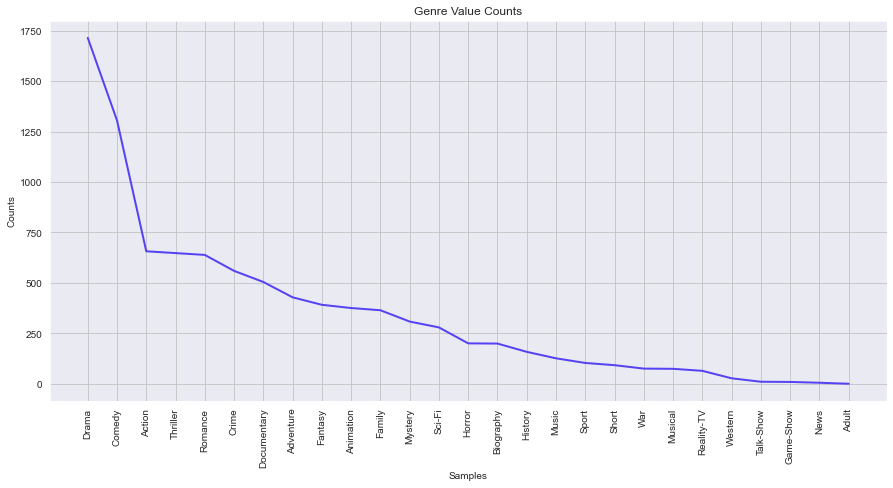

Adding 22 genre flag features


Director:
# values = 2692
# distinct values = 2046


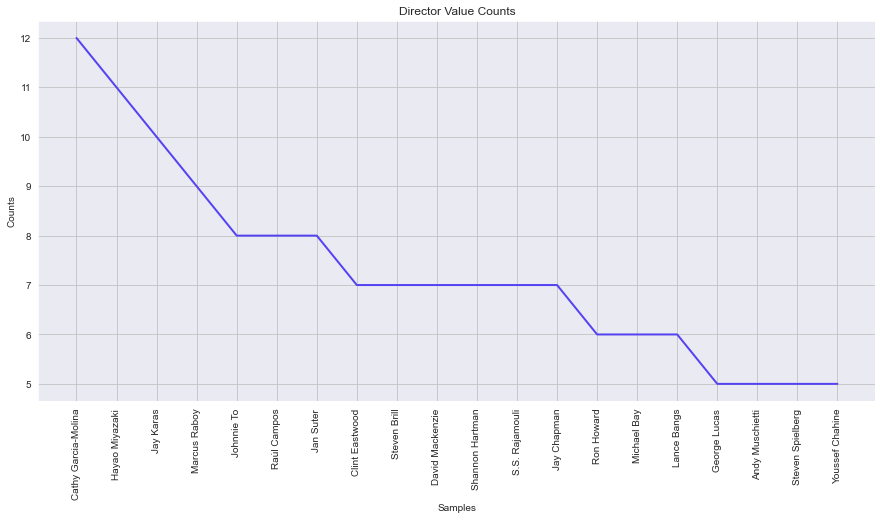

Adding 3 director flag features


Actors:
# values = 13045
# distinct values = 9600


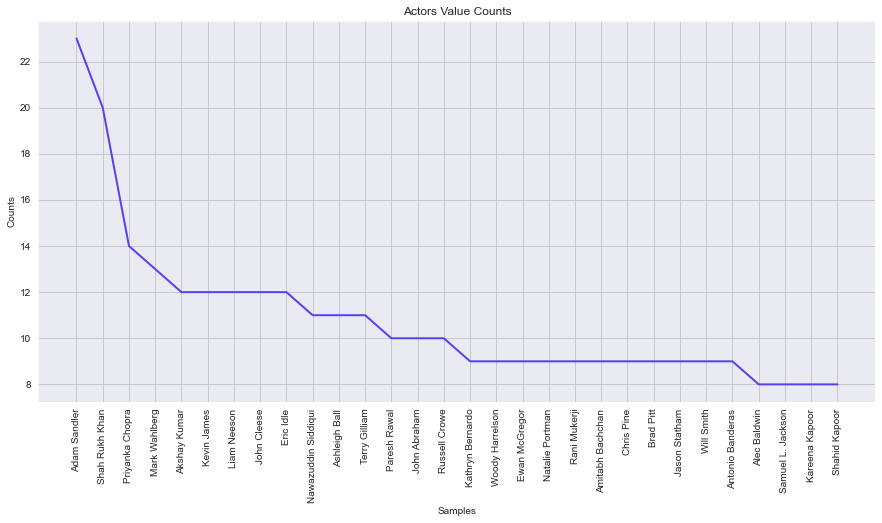

Adding 15 actors flag features




(3603, 61)

,Title id,Title,IMDb Score,Rotten Tomatoes Score,Hidden Gem Score,Metacritic Score,Awards Received,Awards Nominated For,IMDb Votes,Summary,Label,Series or Movie_Movie,Series or Movie_Series,Runtime_1-2 hour,Runtime_30-60 mins,Runtime_< 30 minutes,Runtime_> 2 hrs,Grouped Rating_adult,Grouped Rating_child,Grouped Rating_teen,Grouped Rating_unrated,Drama_f,Comedy_f,Action_f,Thriller_f,Romance_f,Crime_f,Documentary_f,Adventure_f,Fantasy_f,Animation_f,Family_f,Mystery_f,Sci-Fi_f,Horror_f,Biography_f,History_f,Music_f,Sport_f,Short_f,War_f,Musical_f,Reality-TV_f,Cathy Garcia-Molina_f,Hayao Miyazaki_f,Jay Karas_f,Adam Sandler_f,Shah Rukh Khan_f,Priyanka Chopra_f,Mark Wahlberg_f,Liam Neeson_f,Eric Idle_f,John Cleese_f,Kevin James_f,Akshay Kumar_f,Ashleigh Ball_f,Nawazuddin Siddiqui_f,Terry Gilliam_f,Paresh Rawal_f,Russell Crowe_f,John Abraham_f
0,0,Alice,6.600000,75.000000,3.500000,67.000000,1.000000,7.000000,13379.000000,"While investigating a string of murders, a detective is stunned to encounter time travelers — especially a professor whos a dead ringer for his mother.",0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
395,395,Do You Like Brahms?,7.900000,NaN,8.800000,NaN,NaN,NaN,316.000000,"While struggling to find her footing after starting later than her peers, a violin student falls for a successful pianist with a lonely soul.",0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
396,396,Connected,6.600000,73.000000,7.500000,NaN,4.000000,5.000000,1961.000000,"Argentine DJ Hernán Cattáneo, known for his house music innovations, invites a symphonic orchestra for a four-night run at Buenos Aires Teatro Colón.",0,1,0,0,1,0,0,0,0,0,1,0,0,1,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,The Girl on the Train,6.500000,44.000000,2.600000,48.000000,4.000000,12.000000,169614.000000,A troubled divorcée fixates on a seemingly ideal couple from afar until a shocking observation sends her spiraling straight into a knotty murder case.,0,1,0,0,0,0,1,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,Geez & Ann,8.000000,NaN,9.000000,NaN,NaN,NaN,40.000000,"After falling for Geez, a heartthrob at school, Ann must confront family opposition, heartache and deception as their romance struggles.",0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [10]:
def id_key_values(df, text_feature, limit = ''):
    # append all feature values into one body of text separated by commas
    values = ', '.join(df[~pd.isna(df[text_feature])][text_feature]).split(', ')    
    print('# values = ' + str(len(values)))
    
    distinct_values = list(set(values))
    print('# distinct values = ' + str(len(distinct_values)))
    
    fdist = FreqDist(values)
    
    if limit == '':
        limit = len(distinct_values)
    plt.figure(figsize = (15, 7))
    fdist.plot(limit, title = text_feature + ' Value Counts')
    
    df_fdist = pd.DataFrame.from_dict(fdist, orient='index')
    df_fdist.columns = ['Frequency']
    df_fdist.index.name = 'Value'

    return(df_fdist.reset_index().sort_values(by = 'Frequency', ascending = False))


def key_value_f(text, key_value):
    if ~pd.isna(text):
        values = text.split(', ')
        occurrences = [value for value in values if value == key_value]
        if len(occurrences) > 0:
            return 1
        else:
            return 0
        
    else:
        return 0

    
# Define dictionary of values required for each feature
key_value_feat_dict = {'feature': ['Genre', 'Director', 'Actors'], 
                       'fdist_limit': ['', 20, 30],
                       'frequency_limit': [50, 10, 10]}

for feat in range(len(key_value_feat_dict)):
    print(key_value_feat_dict['feature'][feat] + ':')
    # return frequency of the top fdist_limit unique values for the feature 
    fdist = id_key_values(label_file, key_value_feat_dict['feature'][feat], 
                          key_value_feat_dict['fdist_limit'][feat])
    
    # create list of the top frequency_limit most occuring values for the feature to create value flags for
    key_values = fdist[fdist['Frequency'] >= key_value_feat_dict['frequency_limit'][feat]]['Value'].to_list()
    print('Adding ' + str(len(key_values)) + ' ' +
          str(key_value_feat_dict['feature'][feat].lower()) + ' flag features\n\n')
    
    # save key values
    with open(path + 'output_data//' + str(key_value_feat_dict['feature'][feat].lower()) + '_key_values.pkl', 'wb') as file:
        pickle.dump(key_values, file)
    
    # update any missing values in the feature to be a blank space to avoid errors
    label_file.loc[pd.isna(label_file[key_value_feat_dict['feature'][feat]]),
                   key_value_feat_dict['feature'][feat]] = ' '
    
    # create a value flag for chosen values
    for value in key_values:
        label_file[value + '_f'] = label_file[key_value_feat_dict['feature'][feat]].apply(lambda x: key_value_f(x, value))
        
    # remove i=original feature column
    label_file.drop(key_value_feat_dict['feature'][feat],
                    axis = 1, inplace = True)

display(label_file.shape)
display(label_file.head())

#### 4c) NLP feature engineering of text feature = Summary
As we have an abundance of features including Genre based features it wasn't deemed necessary to go beyond sentiment analyis & pca of embeddings to represent the summary. We could use bag of words, tf-idf and more however that is something to consider if the Model performance is poor.

**4c) i. Clean Summary feature**

In [11]:
def preprocess_text(text):
    # convert all text to lowercase & remove punctuation & characters & strip
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    
    ## tokenize
    words = word_tokenize(text)
    
    ## get stop word list
    sws = stopwords.words("english")
    
    ## remove stop words
    no_stopwords = [word for word in words if word not in sws]
    
    # transform words back into string
    text = ' '.join(no_stopwords)
    
    return text    

# clean summary feature
label_file['Clean Summary'] = label_file['Summary'].apply(lambda x: preprocess_text(x))

**4c) ii. Get sentiment scores**

In [12]:
# calculate sentiment score
label_file['Summary Sentiment Score'] = label_file['Clean Summary'].apply(lambda x: TextBlob(x).sentiment.polarity)

display(label_file['Summary Sentiment Score'].describe())

count   3603.000000
mean       0.049719
std        0.268747
min       -1.000000
25%       -0.064621
50%        0.000000
75%        0.200000
max        1.000000
Name: Summary Sentiment Score, dtype: float64

**4c) iii. Get embeddings**

In [13]:
%%time
# create array from text column
x = label_file.loc[:, 'Clean Summary'].values
print(len(x))
print(x)

# create embeddings
os.chdir('C:\\Users\\claud\\Documents\\code\\')
model = SentenceTransformer('paraphrase-distilroberta-base-v1')
roberta = model.encode(x)
display(roberta.shape)
display(roberta)

3603
['investigating string murders detective stunned encounter time travelers especially professor whos dead ringer mother'
 'struggling find footing starting later peers violin student falls successful pianist lonely soul'
 'argentine dj hernán cattáneo known house music innovations invites symphonic orchestra fournight run buenos aires teatro colón'
 ...
 'playing straight man partners half size ventriloquist jeff dunham one americas funniest comics slays audiences across country'
 'troubled teens get dose prison life interacting hardened inmates try intervene wayward kids land jail'
 'madagascar goes wild holiday spirit set valentines day christmasthemed tales featuring everyones favorite animal characters']


(3603, 768)

array([[-0.24455734,  0.10481718,  0.3543388 , ...,  0.6367721 ,
        -0.24006216,  0.3265691 ],
       [ 0.0641323 ,  0.43235946,  0.2047125 , ...,  0.43033642,
         0.17799708, -0.08174045],
       [ 0.06697009,  0.00771234,  0.39961383, ...,  0.24203071,
         0.02389939, -0.19335544],
       ...,
       [ 0.142475  ,  0.22981142,  0.16800272, ...,  0.06512679,
         0.14045559, -0.308328  ],
       [-0.10921635,  0.18740061, -0.02940985, ...,  0.51210773,
        -0.24028683,  0.2241435 ],
       [-0.34092093, -0.00970569,  0.3999281 , ...,  0.18125887,
        -0.04206515,  0.02902708]], dtype=float32)

Wall time: 2min 19s


**4c) iv. Apply PCA to reduce embedding dimensions from 768 to 2**

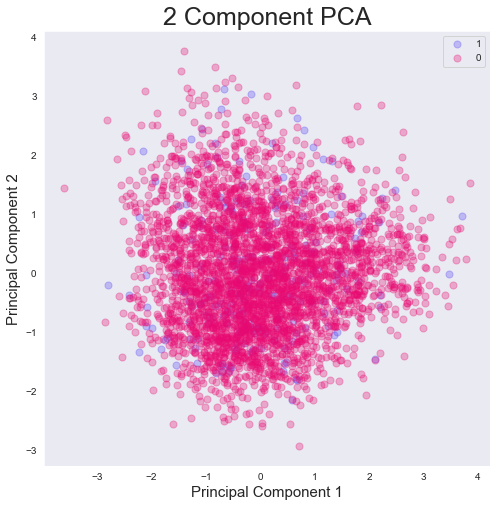

In [14]:
# use pca to reduce from768 to 2 dimensions
pca = PCA(n_components = 2)
principal_components = pca.fit_transform(roberta)

# transfer pca components to data frame with label column
pca_df = pd.DataFrame(data = principal_components,
                      columns = ['pc1', 'pc2'])
pca_df = label_file.join(pca_df)

# plot principal components by label
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Component PCA', fontsize = 25)
labels = [1, 0]
colours = palette[:2]
for label, colour in zip(labels, colours):
    indicesToKeep = pca_df['Label'] == label
    ax.scatter(pca_df.loc[indicesToKeep, 'pc1'],
               pca_df.loc[indicesToKeep, 'pc2'],
               c = colour,
               s = 50,
               alpha = 0.3)
ax.legend(labels)
ax.grid()

**4c) v. Choose optimal number of embedding components to add as features**

,n_components,explained_variance,log_explained_variance
0,2,5.200000,-2.956512
1,4,8.810000,-2.429283
2,6,12.040000,-2.116936
3,8,14.920000,-1.902468
4,10,17.640000,-1.735001
5,12,20.060000,-1.606442
6,14,22.390000,-1.496556
7,16,24.600000,-1.402424
8,18,26.710000,-1.320132
9,20,28.710000,-1.247925


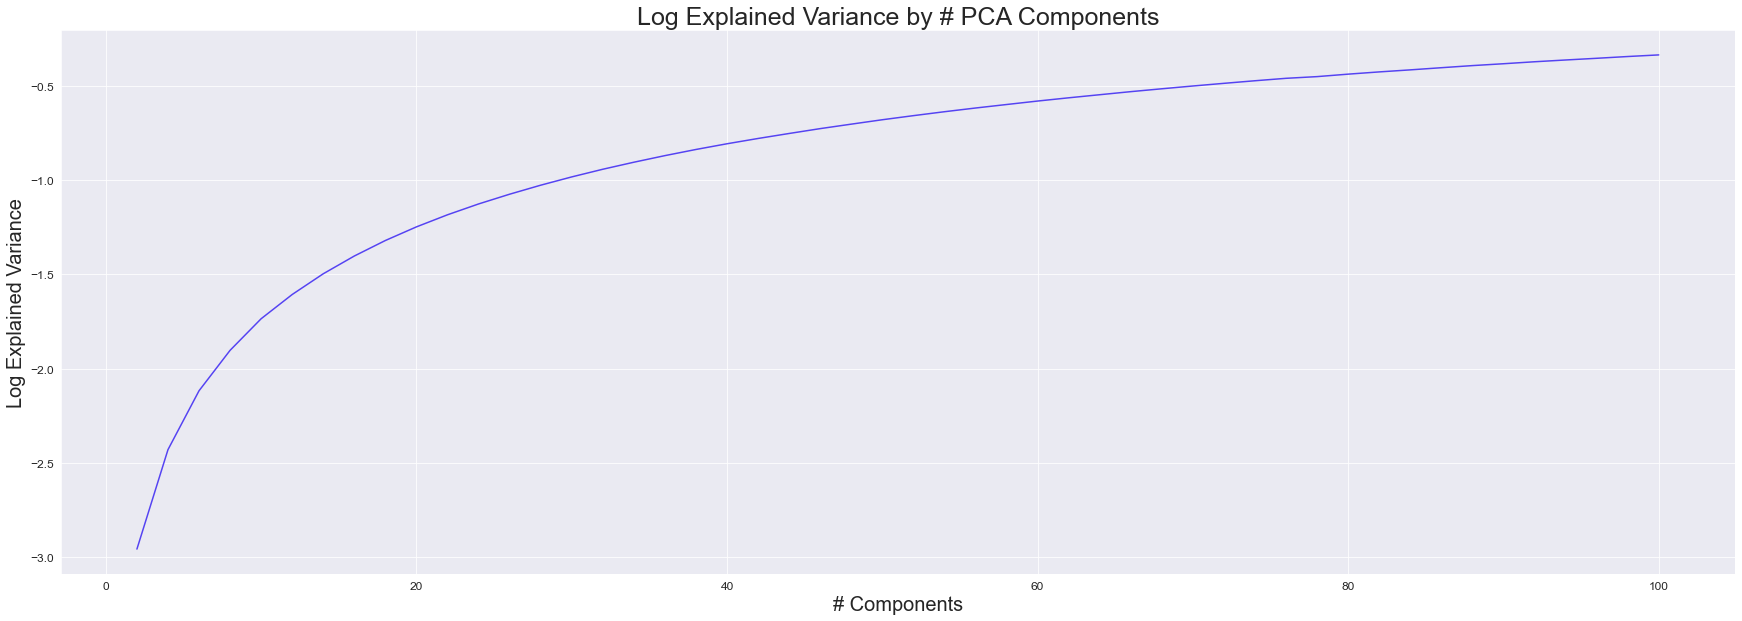

In [15]:
# get explained variance for different choices of n_components within PCA
def explained_variance(embeddings, n_components, print_f = False, return_f = True):
    pca = PCA(n_components = n_components)
    principal_components = pca.fit_transform(embeddings)
    ev = round(pca.explained_variance_ratio_.sum() * 100, 2)
    if print_f:
        print('Together the ' + str(n_components) + ' components contain ' +
              str(ev) + '% of the information.')
    
    if return_f:
        return ev, pca.explained_variance_ratio_
    
n_component_explained_variance_df = pd.DataFrame(data = {'n_components' : list(range(2, 101, 2))})
n_component_explained_variance_df['explained_variance'] =\
n_component_explained_variance_df['n_components'].apply(lambda x: explained_variance(embeddings = roberta,
                                                                                     n_components = x)[0])

# get log of explained variance
n_component_explained_variance_df['log_explained_variance'] =\
np.log(n_component_explained_variance_df['explained_variance'] / 100)
display(n_component_explained_variance_df.head(30))

# use elbow method to determine best choice of n_components
sns.set_style('darkgrid')
plt.figure(figsize = (30, 10))
ax = sns.lineplot(x = 'n_components', y = 'log_explained_variance',
                  markers = True, data = n_component_explained_variance_df)
ax.set_title('Log Explained Variance by # PCA Components', fontsize = 25)
ax.set_ylabel('Log Explained Variance', fontsize = 20)
ax.set_xlabel('# Components', fontsize = 20)
plt.yticks(size = 12)
plt.xticks(size = 12)

plt.show()

**4c) vi. Apply PCA to reduce dimensions from 768 to 50 and add as features**

In [16]:
# choosing to reduce to 50 features to get 50% of the information as there is no clear elbow 
# and from 50, adding an extra feature won't even provide an extra 1% of the information
n_components = 50
pca = PCA(n_components = n_components)
principal_components = pca.fit_transform(roberta)
explained_variance(embeddings = roberta, n_components = n_components, print_f = True, return_f = False)

# transfer components to label file
components = list(range(1, n_components + 1))
component_features = ['PC ' + str(item) for item in components]
pca_df = pd.DataFrame(data = principal_components,
                      columns = component_features)
pca_df.reset_index(drop = True, inplace = True)

# join on entire label_file
label_file.reset_index(drop = True, inplace = True)
label_file = label_file.join(pca_df)

# drop unnecessary text columns
label_file.drop(['Summary', 'Clean Summary'], axis = 1, inplace = True)

display(label_file.shape)
display(label_file.head())

Together the 50 components contain 50.67% of the information.


(3603, 111)

,Title id,Title,IMDb Score,Rotten Tomatoes Score,Hidden Gem Score,Metacritic Score,Awards Received,Awards Nominated For,IMDb Votes,Label,Series or Movie_Movie,Series or Movie_Series,Runtime_1-2 hour,Runtime_30-60 mins,Runtime_< 30 minutes,Runtime_> 2 hrs,Grouped Rating_adult,Grouped Rating_child,Grouped Rating_teen,Grouped Rating_unrated,Drama_f,Comedy_f,Action_f,Thriller_f,Romance_f,Crime_f,Documentary_f,Adventure_f,Fantasy_f,Animation_f,Family_f,Mystery_f,Sci-Fi_f,Horror_f,Biography_f,History_f,Music_f,Sport_f,Short_f,War_f,Musical_f,Reality-TV_f,Cathy Garcia-Molina_f,Hayao Miyazaki_f,Jay Karas_f,Adam Sandler_f,Shah Rukh Khan_f,Priyanka Chopra_f,Mark Wahlberg_f,Liam Neeson_f,Eric Idle_f,John Cleese_f,Kevin James_f,Akshay Kumar_f,Ashleigh Ball_f,Nawazuddin Siddiqui_f,Terry Gilliam_f,Paresh Rawal_f,Russell Crowe_f,John Abraham_f,Summary Sentiment Score,PC 1,PC 2,PC 3,PC 4,PC 5,PC 6,PC 7,PC 8,PC 9,PC 10,PC 11,PC 12,PC 13,PC 14,PC 15,PC 16,PC 17,PC 18,PC 19,PC 20,PC 21,PC 22,PC 23,PC 24,PC 25,PC 26,PC 27,PC 28,PC 29,PC 30,PC 31,PC 32,PC 33,PC 34,PC 35,PC 36,PC 37,PC 38,PC 39,PC 40,PC 41,PC 42,PC 43,PC 44,PC 45,PC 46,PC 47,PC 48,PC 49,PC 50
0,0,Alice,6.600000,75.000000,3.500000,67.000000,1.000000,7.000000,13379.000000,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.100000,-0.716252,-0.314516,1.282396,0.287570,-0.633176,0.000586,-0.131588,-0.976245,-0.908923,-2.867811,-0.073949,-0.007425,0.191187,0.420787,-0.721545,-0.784760,-0.419608,-0.080717,0.790921,-0.079877,-0.013646,-0.042053,0.187084,0.225885,0.229385,0.063706,-0.834338,-0.777262,0.713264,0.883938,0.211103,-0.345172,0.883315,0.798204,-0.952768,-0.212655,0.315574,0.660882,0.763853,0.894385,-0.403871,0.218845,-0.620911,0.485023,-0.536382,0.566438,0.014420,0.396327,-1.039109,-0.589160
1,395,Do You Like Brahms?,7.900000,NaN,8.800000,NaN,NaN,NaN,316.000000,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.162500,-1.093729,1.876351,0.527830,1.027895,-0.458980,0.587847,-0.189319,1.232237,-0.369278,1.148953,0.430350,-0.030827,-0.509201,2.327305,-0.411575,-0.717657,0.172921,0.661164,-0.859795,-0.430926,-0.471244,0.751459,-0.803842,-0.190330,0.857827,-0.840330,-0.909267,-0.868657,-0.154038,0.761136,1.198571,-0.201682,0.863825,0.638635,0.578779,-0.435813,-0.788379,0.178034,-1.500645,1.142484,-0.066357,-1.244451,0.447519,-0.432686,-1.161908,-0.036712,-0.345830,0.214265,-0.816803,-0.599684
2,396,Connected,6.600000,73.000000,7.500000,NaN,4.000000,5.000000,1961.000000,0,1,0,0,1,0,0,0,0,0,1,0,0,1,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,2.109617,1.455054,-0.371671,-0.292224,-0.229532,1.563698,-0.120433,0.685080,-0.000402,-1.112118,1.164731,0.941369,0.139441,-0.257562,-0.663435,1.113153,-0.978819,0.203381,0.268712,-0.121058,0.149481,-1.570890,0.052486,-1.604925,-0.134360,0.574798,-0.670841,-0.904594,-0.704543,0.965110,0.098038,0.167387,0.100620,-0.364152,0.055019,-0.802061,-0.030563,0.192560,0.039807,-0.017621,1.119730,0.785456,0.401270,-0.841902,0.176716,-1.339089,-0.036599,-0.523341,-0.344866,0.190475
3,1,The Girl on the Train,6.500000,44.000000,2.600000,48.000000,4.000000,12.000000,169614.000000,0,1,0,0,0,0,1,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.100000,-0.338825,1.181432,-0.092740,-1.274435,-1.341645,-0.626623,-1.273450,-0.223152,-0.470637,-0.741067,-0.344546,-0.161939,0.057589,-0.469794,-0.599930,-0.890802,0.370752,-0.355217,0.884080,-0.609705,0.246513,0.096614,0.255384,0.348060,-0.308350,-1.571420,0.123098,-0.456696,-0.120299,0.690545,-0.627425,-0.498030,-0.587984,0.124077,0.117290,-0.041087,0.226655,-0.536003,0.492933,-0.079123,0.350247,0.317667,0.013562,0.499972,-0.352400,0.418387,0.194268,0.097017,0.346538,-0.110097
4,2,Geez & Ann,8.000000,NaN,9.000000,NaN,NaN,NaN,40.000000,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00

#### 4d) Handling Nulls
- All score columns along with IMDb Votes are missing values which we will umpute as mean value
- Awards received/nominated can have missing values replaced with 0

In [17]:
display(label_file.describe())
display(label_file.isna().sum()[:10])

# replace null values with 0 for columns related to awards
label_file['Awards Received'].fillna(0, inplace = True)
label_file['Awards Nominated For'].fillna(0, inplace = True)

# impute other columns' missing values with mean
cols_to_impute = ['IMDb Score', 'Rotten Tomatoes Score', 'Hidden Gem Score', 'Metacritic Score', 'IMDb Votes']
def impute_mean(df_col):
    if df_col.isna().sum() > 0:
        col_mean = df_col.mean()
        df_col.fillna(col_mean, inplace = True)
        
        return df_col       
for col in cols_to_impute:
    label_file[col] = impute_mean(label_file[col])

display(label_file.describe())
display(label_file.isna().sum())

,Title id,IMDb Score,Rotten Tomatoes Score,Hidden Gem Score,Metacritic Score,Awards Received,Awards Nominated For,IMDb Votes,Label,Series or Movie_Movie,Series or Movie_Series,Runtime_1-2 hour,Runtime_30-60 mins,Runtime_< 30 minutes,Runtime_> 2 hrs,Grouped Rating_adult,Grouped Rating_child,Grouped Rating_teen,Grouped Rating_unrated,Drama_f,Comedy_f,Action_f,Thriller_f,Romance_f,Crime_f,Documentary_f,Adventure_f,Fantasy_f,Animation_f,Family_f,Mystery_f,Sci-Fi_f,Horror_f,Biography_f,History_f,Music_f,Sport_f,Short_f,War_f,Musical_f,Reality-TV_f,Cathy Garcia-Molina_f,Hayao Miyazaki_f,Jay Karas_f,Adam Sandler_f,Shah Rukh Khan_f,Priyanka Chopra_f,Mark Wahlberg_f,Liam Neeson_f,Eric Idle_f,John Cleese_f,Kevin James_f,Akshay Kumar_f,Ashleigh Ball_f,Nawazuddin Siddiqui_f,Terry Gilliam_f,Paresh Rawal_f,Russell Crowe_f,John Abraham_f,Summary Sentiment Score,PC 1,PC 2,PC 3,PC 4,PC 5,PC 6,PC 7,PC 8,PC 9,PC 10,PC 11,PC 12,PC 13,PC 14,PC 15,PC 16,PC 17,PC 18,PC 19,PC 20,PC 21,PC 22,PC 23,PC 24,PC 25,PC 26,PC 27,PC 28,PC 29,PC 30,PC 31,PC 32,PC 33,PC 34,PC 35,PC 36,PC 37,PC 38,PC 39,PC 40,PC 41,PC 42,PC 43,PC 44,PC 45,PC 46,PC 47,PC 48,PC 49,PC 50
count,3603.000000,3598.000000,1593.000000,3598.000000,1101.000000,1750.000000,2198.000000,3598.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000
mean,1808.533444,7.081240,67.702448,5.976904,59.729337,8.637143,14.814377,45405.933296,0.061060,0.625590,0.374410,0.435193,0.023036,0.387732,0.154038,0.293089,0.052734,0.252290,0.401887,0.475715,0.362198,0.182348,0.179850,0.177352,0.155426,0.140161,0.119067,0.108798,0.104357,0.101304,0.085762,0.077713,0.055787,0.055509,0.044130,0.035248,0.028865,0.025812,0.021094,0.020816,0.018041,0.003331,0.003053,0.002775,0.006384,0.005551,0.003886,0.003608,0.003331,0.003331,0.003331,0.003331,0.003331,0.003053,0.003053,0.003053,0.002775,0.002775,0.002775,0.049719,0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000
std,1045.976242,0.875494,24.697071,2.363809,16.313557,17.241045,29.693015,122196.372467,0.239474,0.484037,0.484037,0.495851,0.150040,0.487301,0.361036,0.455242,0.223533,0.434387,0.490347,0.499479,0.480702,0.386185,0.384116,0.382020,0.362361,0.347202,0.323913,0.311429,0.305766,0.301773,0.280051,0.267757,0.229541,0.229003,0.205412,0.184433,0.167450,0.158596,0.143716,0.142788,0.133116,0.057623,0.055177,0.052617,0.079653,0.074308,0.062222,0.059967,0.057623,0.057623,0.057623,0.057623,0.057623,0.055

Title id                    0
Title                       0
IMDb Score                  5
Rotten Tomatoes Score    2010
Hidden Gem Score            5
Metacritic Score         2502
Awards Received          1853
Awards Nominated For     1405
IMDb Votes                  5
Label                       0
dtype: int64

,Title id,IMDb Score,Rotten Tomatoes Score,Hidden Gem Score,Metacritic Score,Awards Received,Awards Nominated For,IMDb Votes,Label,Series or Movie_Movie,Series or Movie_Series,Runtime_1-2 hour,Runtime_30-60 mins,Runtime_< 30 minutes,Runtime_> 2 hrs,Grouped Rating_adult,Grouped Rating_child,Grouped Rating_teen,Grouped Rating_unrated,Drama_f,Comedy_f,Action_f,Thriller_f,Romance_f,Crime_f,Documentary_f,Adventure_f,Fantasy_f,Animation_f,Family_f,Mystery_f,Sci-Fi_f,Horror_f,Biography_f,History_f,Music_f,Sport_f,Short_f,War_f,Musical_f,Reality-TV_f,Cathy Garcia-Molina_f,Hayao Miyazaki_f,Jay Karas_f,Adam Sandler_f,Shah Rukh Khan_f,Priyanka Chopra_f,Mark Wahlberg_f,Liam Neeson_f,Eric Idle_f,John Cleese_f,Kevin James_f,Akshay Kumar_f,Ashleigh Ball_f,Nawazuddin Siddiqui_f,Terry Gilliam_f,Paresh Rawal_f,Russell Crowe_f,John Abraham_f,Summary Sentiment Score,PC 1,PC 2,PC 3,PC 4,PC 5,PC 6,PC 7,PC 8,PC 9,PC 10,PC 11,PC 12,PC 13,PC 14,PC 15,PC 16,PC 17,PC 18,PC 19,PC 20,PC 21,PC 22,PC 23,PC 24,PC 25,PC 26,PC 27,PC 28,PC 29,PC 30,PC 31,PC 32,PC 33,PC 34,PC 35,PC 36,PC 37,PC 38,PC 39,PC 40,PC 41,PC 42,PC 43,PC 44,PC 45,PC 46,PC 47,PC 48,PC 49,PC 50
count,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000,3603.000000
mean,1808.533444,7.081240,67.702448,5.976904,59.729337,4.195115,9.037469,45405.933296,0.061060,0.625590,0.374410,0.435193,0.023036,0.387732,0.154038,0.293089,0.052734,0.252290,0.401887,0.475715,0.362198,0.182348,0.179850,0.177352,0.155426,0.140161,0.119067,0.108798,0.104357,0.101304,0.085762,0.077713,0.055787,0.055509,0.044130,0.035248,0.028865,0.025812,0.021094,0.020816,0.018041,0.003331,0.003053,0.002775,0.006384,0.005551,0.003886,0.003608,0.003331,0.003331,0.003331,0.003331,0.003331,0.003053,0.003053,0.003053,0.002775,0.002775,0.002775,0.049719,0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000
std,1045.976242,0.874886,16.418941,2.362168,9.015154,12.766187,24.289732,122111.531540,0.239474,0.484037,0.484037,0.495851,0.150040,0.487301,0.361036,0.455242,0.223533,0.434387,0.490347,0.499479,0.480702,0.386185,0.384116,0.382020,0.362361,0.347202,0.323913,0.311429,0.305766,0.301773,0.280051,0.267757,0.229541,0.229003,0.205412,0.184433,0.167450,0.158596,0.143716,0.142788,0.133116,0.057623,0.055177,0.052617,0.079653,0.074308,0.062222,0.059967,0.057623,0.057623,0.057623,0.057623,0.057623,0.05517

Title id                   0
Title                      0
IMDb Score                 0
Rotten Tomatoes Score      0
Hidden Gem Score           0
Metacritic Score           0
Awards Received            0
Awards Nominated For       0
IMDb Votes                 0
Label                      0
Series or Movie_Movie      0
Series or Movie_Series     0
Runtime_1-2 hour           0
Runtime_30-60 mins         0
Runtime_< 30 minutes       0
Runtime_> 2 hrs            0
Grouped Rating_adult       0
Grouped Rating_child       0
Grouped Rating_teen        0
Grouped Rating_unrated     0
Drama_f                    0
Comedy_f                   0
Action_f                   0
Thriller_f                 0
Romance_f                  0
Crime_f                    0
Documentary_f              0
Adventure_f                0
Fantasy_f                  0
Animation_f                0
Family_f                   0
Mystery_f                  0
Sci-Fi_f                   0
Horror_f                   0
Biography_f   

<a id="id_5"></a>
## 5. Save Label File

In [18]:
label_file.to_pickle(path + 'output_data//label_file_mum.pkl')

[back to the top](#id_0)